In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polyphase

In [3]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import os, shutil
from collections import Counter
plt.rcParams.update({"text.usetex": True})

In [4]:
def touchup3d(ax):
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    ax.zaxis._axinfo['juggled'] = (1,2,0)

## Make interactive plot

In [5]:
data = np.load('../figures/deltaspace/plot_IDIC_PTB7-Th.npz')
x = data['arr_0']
sm = data['arr_1']   
polymer = data['arr_2']
cvalues = data['arr_3']
data.close()

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=3,subplot_titles=('Phase 1','Phase 2', 'Phase 3'),
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
    horizontal_spacing=0.15)
colorbar_x = [0.3, 0.66, 1.0]
scene = dict(camera= dict(eye=dict(x=1.15, y=1.15, z=0.8)),
             aspectmode='cube', xaxis = dict(range=[12,23],title='dD'), 
             yaxis = dict(range=[0,12],title='dP'),
             zaxis = dict(range=[0,12],title='dH'))
for i in range(3):
    fig.add_trace(go.Scatter3d(
        x=x[:,0], y=x[:,1], z=x[:,2],mode='markers',
        marker=dict(size=5,color=cvalues[:,i],colorscale='RdBu',
        colorbar=dict(thickness=10, x = colorbar_x[i]), opacity=0.7),
        showlegend=False),
                  row=1,col=i+1)
    fig.add_trace(go.Scatter3d(
        x=[sm[0]], y=[sm[1]], z=[sm[2]],mode='markers',
        marker=dict(size=10, color='black', symbol='diamond'),
        showlegend=False if i>0 else True,
        name ='small molecule'),
                  row=1,col=i+1)
    
    fig.add_trace(go.Scatter3d(
        x=[polymer[0]], y=[polymer[1]], z=[polymer[2]],mode='markers',
        marker=dict(size=10, color='black', symbol='cross'),
        showlegend=False if i>0 else True,
        name ='polymer'),
                  row=1,col=i+1)  
    
    key = 'scene{}'.format(i+1)
    fig['layout'][key].update(scene)

fig.write_html('../figures/deltaspace/interactive.html')

## Sample in Solubulity space

Here, we sample a solvent in the solubility space and generate a vector of solubulities.
These parameters are then combined with a set of solubulity parameters of polymer and small molecule to compute chi values. Degrees of polymerization are also calculated using :$M = \frac{MW*\rho}{Volume}$ 

In [5]:
NUM_PER_DIMENSION = 2
delta_d = np.linspace(15,20, num=NUM_PER_DIMENSION)
delta_p = np.linspace(1,10, num=NUM_PER_DIMENSION)
delta_h = np.linspace(1,10, num=NUM_PER_DIMENSION)
solvents = list(product(delta_d, delta_p, delta_h))
solvents = np.asarray(solvents)


In [6]:
SM = [['IDIC',18.7,7.2,4.5,1011,1]]
polymers = [['PTB7-Th',18.56,2.3,3.21,5e4,1]]

SM_df = pd.DataFrame.from_records(SM, columns=['name','dD','dP','dH','MW', 'rho'])
polymer_df = pd.DataFrame.from_records(polymers, columns=['name','dD','dP','dH','MW', 'rho'])
solvents_df = pd.DataFrame.from_records(np.hstack((np.arange(len(solvents)).reshape(-1,1), solvents)),
                                        columns=['name','dD','dP','dH'])

In [7]:
def get_system(indx):
    delta_solvent = solvents_df.loc[indx[0],['dD','dP','dH']].tolist()
    M_solv = 1
    MVol = 100

    delta_sm = SM_df.loc[indx[1],['dD','dP','dH']].tolist()
    M_sm = (SM_df.loc[indx[1],'MW']/SM_df.loc[indx[1],'rho'])*(1/MVol)
    
    delta_polymer = polymer_df.loc[indx[2],['dD','dP','dH']].tolist()
    M_polymer = (polymer_df.loc[indx[2],'MW']/polymer_df.loc[indx[2],'rho'])*(1/MVol)
    
    M = [M_polymer, M_sm, M_solv]
    chi,_ = polyphase.get_chi_vector([delta_polymer,delta_sm,delta_solvent], MVol, 2)
 
    out = [polymer_df.loc[indx[2],'name'],SM_df.loc[indx[1],'name'],solvents_df.loc[indx[0],'name'],
           chi[0], chi[1], chi[2], M,
           delta_polymer, delta_sm,  delta_solvent
    ]   
    return out

axes = [np.arange(0,len(solvents_df)),np.arange(0,len(SM_df)),np.arange(0,len(polymer_df))]
df = pd.DataFrame(get_system(i) for i in product(*axes))
df.columns =['polymer', 'SM','solvent','chi12','chi13','chi23',
                 'dop','delta_polymer','delta_SM','delta_solvent'] 
print('Total of {} systems'.format(len(df)))
df.head()

Total of 8 systems


,polymer,SM,solvent,chi12,chi13,chi23,dop,delta_polymer,delta_SM,delta_solvent
0,PTB7-Th,IDIC,0.0,1.370081,1.111655,2.921045,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[15.0, 1.0, 1.0]"
1,PTB7-Th,IDIC,1.0,1.370081,2.764198,3.642679,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[15.0, 1.0, 10.0]"
2,PTB7-Th,IDIC,2.0,1.370081,3.420885,1.694267,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[15.0, 10.0, 1.0]"
3,PTB7-Th,IDIC,3.0,1.370081,5.073427,2.415901,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[15.0, 10.0, 10.0]"
4,PTB7-Th,IDIC,4.0,1.370081,0.686693,2.439955,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[20.0, 1.0, 1.0]"


In [49]:
from math import pi
def get_ternary_coords(point):
    """ Compute 2d embedding of a 3d hyperplane """
    a,b,c = point
    x = 0.5-a*np.cos(pi/3)+b/2;
    y = 0.866-a*np.sin(pi/3)-b*(1/np.tan(pi/6)/2);
    
    return [x,y]

def get_simplex_area(engine, simplex_id):
    matrix = []
    for s in engine.simplices[simplex_id]:
        v = engine.grid[:,s]
        matrix.append(get_ternary_coords(v))

    matrix = np.hstack((np.asarray(matrix), np.ones((3,1))))
    area = 0.5*np.linalg.det(matrix)
    return np.abs(area)

def get_phase_area(engine, phase_label):
    total_area = 0
    phase_simplices = np.where(np.asarray(engine.num_comps)==phase_label)[0]
    if len(phase_simplices)==0:
        return 0
    for ps in phase_simplices:
        total_area += get_simplex_area(engine, ps)
    
    return total_area/0.43

0.882633958743203

In [50]:
dirname = '../figures/deltaspace/testcase/'
if os.path.exists(dirname):
    shutil.rmtree(dirname)    
os.makedirs(dirname)

num_simplices = []
for i, row in df.iterrows():
    M = row['dop']
    chi = [row['chi12'], row['chi13'], row['chi23']]
    f = lambda x: polyphase.flory_huggins(x , M, chi)
    engine = polyphase.PHASE(f, 200,3)
    engine.compute(use_parallel=False)
#     phaselabels = engine.num_comps 
#     twophase = np.sum(np.asarray(phaselabels)==2)
#     onephase = np.sum(np.asarray(phaselabels)==1)
#     threephase = np.sum(np.asarray(phaselabels)==3)
    
    num_simplices.append([get_phase_area(engine, 1), get_phase_area(engine, 2),
                          get_phase_area(engine, 3)])
    
    polyphase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
    plt.savefig(dirname+'{}.png'.format(i), bbox_inches='tight', dpi=300)
    plt.close()

Computation took 3.57s
Computation took 3.28s
Computation took 3.40s
Computation took 3.40s
Computation took 3.60s
Computation took 3.35s
Computation took 3.44s
Computation took 3.33s


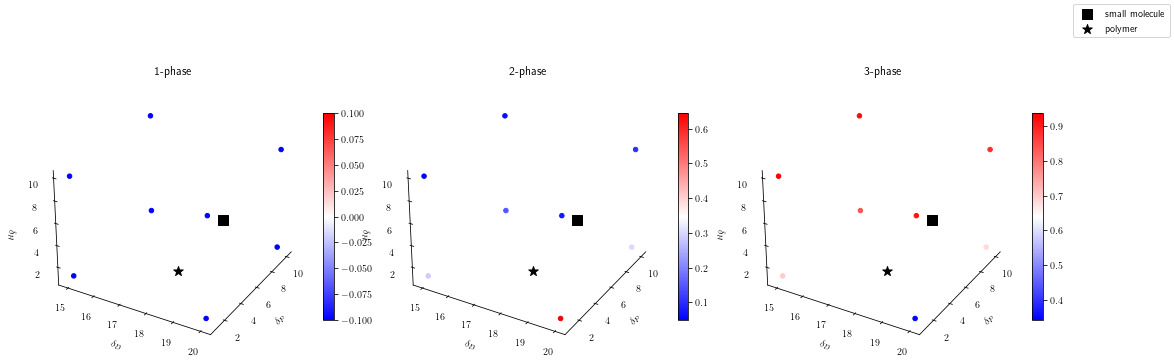

In [51]:
fig, axs = plt.subplots(1,3, figsize=(3*6,6),subplot_kw={'projection':'3d'})
cvalues = np.asarray(num_simplices)
x = np.vstack(df['delta_solvent'].to_numpy())
sm = df['delta_SM'][0]
polymer = df['delta_polymer'][0]
for i,ax in enumerate(axs):
    path = ax.scatter(x[:,0], x[:,1], x[:,2],c=cvalues[:,i],
                      alpha=1.0, cmap='bwr')
    fig.colorbar(path, pad=0.05, ax = ax, fraction=0.035)
    
    ax.scatter(sm[0], sm[1], sm[2], 
               marker='s',s=100,color='k',label='small molecule' if i==2 else '')
    ax.scatter(polymer[0], polymer[1], polymer[2],
               marker='*',s=100,color='k',label='polymer' if i==2 else '')
    ax.set_xlabel(r'$\delta_{D}$')
    ax.set_ylabel(r'$\delta_{P}$')
    ax.set_zlabel(r'$\delta_{H}$')
    ax.set_title('{}-phase'.format(i+1))
    touchup3d(ax)
fig.legend()
plt.show()

## Create a chi-space grid
We generate a uniform grid of chi values in $\chi_{12}, \chi_{13}, \chi_{23}$.

For a given list of degree of polymerizations in M, we generate bunch of phase diagrams and visualize them in the grid.

In [5]:
Mp = 10
chi12 = np.linspace(1.3,1.44, num=5)
chi13 = [0.3,0.6,1,2,3]
chi23 = [0.3,0.6,1,2,3]
chispace = list(product(chi12, chi13, chi23))
chispace = np.asarray(chispace)
df = pd.DataFrame(chispace, columns=['chi12', 'chi13', 'chi23'])

In [6]:
df = pd.read_pickle("../figures/chispace/10.pkl")
df.iloc[37,:]

chi12    1.335
chi13    1.000
chi23    1.000
Name: 37, dtype: float64

In [12]:
dirname = '../figures/chispace/testcase/chinamed/'
if os.path.exists(dirname):
    shutil.rmtree(dirname)    
os.makedirs(dirname)

num_simplices = []
for i, chi in df.iterrows():
    M = [10,10,1]
    f = lambda x: polyphase.flory_huggins(x , M, chi, logapprox=True)
    engine = polyphase.PHASE(f, 200,3)
    engine.compute(use_parallel=False)
    phaselabels = engine.num_comps 
    twophase = np.sum(np.asarray(phaselabels)==2)
    onephase = np.sum(np.asarray(phaselabels)==1)
    threephase = np.sum(np.asarray(phaselabels)==3)
    num_simplices.append([onephase, twophase, threephase])
    
    polyphase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
    fname = '_'.join('{}'.format(i) for i in chi).replace('.','p')
    plt.savefig(dirname+'{}.png'.format(fname), bbox_inches='tight', dpi=300)
    plt.close()
    break

chi12    1.3
chi13    0.3
chi23    0.3
Name: 0, dtype: float64
Computation took 10.56s


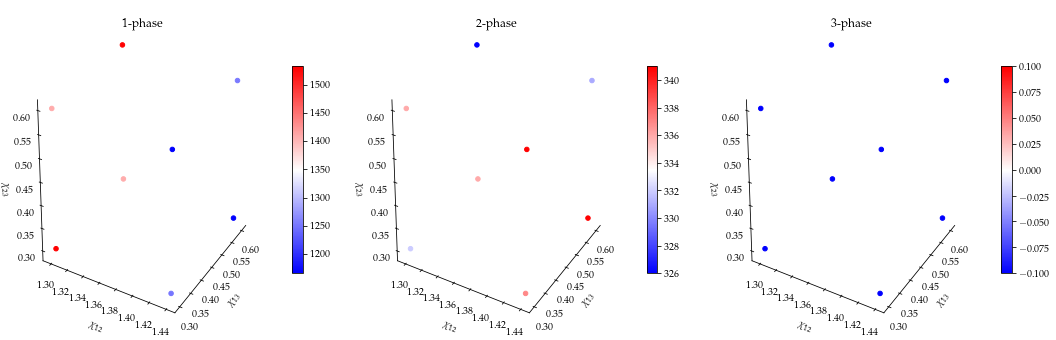

In [41]:
fig, axs = plt.subplots(1,3, figsize=(3*6,6),subplot_kw={'projection':'3d'})
cvalues = np.asarray(num_simplices)
x = df.to_numpy()
for i,ax in enumerate(axs):
    path = ax.scatter(x[:,0], x[:,1], x[:,2],c=cvalues[:,i],
                      alpha=1.0, cmap='bwr')
    fig.colorbar(path, pad=0.05, ax = ax, fraction=0.035)
    
    ax.set_xlabel(r'$\chi_{12}$')
    ax.set_ylabel(r'$\chi_{13}$')
    ax.set_zlabel(r'$\chi_{23}$')
    ax.set_title('{}-phase'.format(i+1))
    touchup3d(ax)
plt.show()